In [1]:
#mlp_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#9 July 2018
#
#train an mlp model on the XO dataset, this executes in about X minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate training and validation data
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
validate = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,9.041684,0.565399,9.059344,0.062451,B,0.0,0.0,1.0
19996,19996,-0.880859,-2.595434,2.740837,-1.897986,B,0.0,0.0,1.0
19997,19997,-0.345764,0.766019,0.840439,1.994796,X,1.0,0.0,0.0
19998,19998,-4.441350,-4.498902,6.321844,-2.349757,X,1.0,0.0,0.0
19999,19999,3.685559,-0.961545,3.808926,-0.255206,B,0.0,0.0,1.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

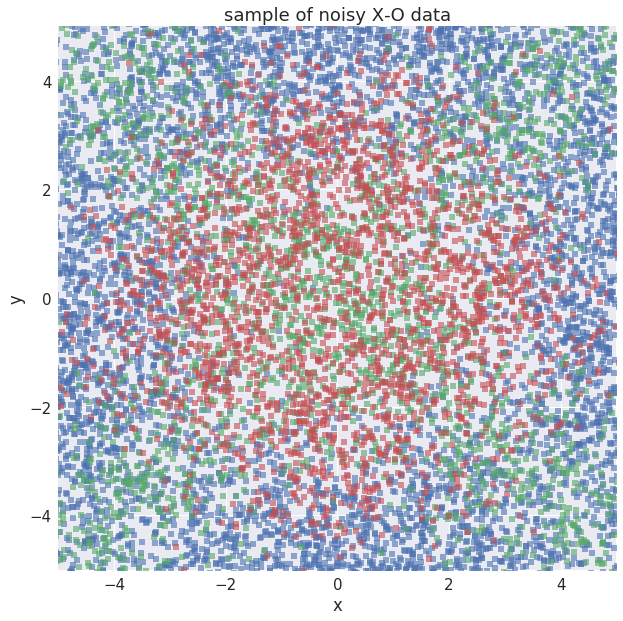

In [6]:
#scatterplot of noisy X-O data
df = train
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/training_data.png')

In [7]:
#note class imbalance in training data
train.groupby('class')['id'].count()

class
B    14842
O     2567
X     2591
Name: id, dtype: int64

In [8]:
#rebalance training data & randomize records
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num')
print train_balanced.groupby('class')['id'].count()
train_balanced.head()

class
B    2567
O    2567
X    2591
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
13846,13846,-8.610029,0.774545,8.644798,3.051876,B,0.0,0.0,1.0,0.000054
7629,7629,3.706237,-4.957302,6.189591,-0.928813,X,1.0,0.0,0.0,0.000082
10296,10296,-3.188753,-4.923798,5.866168,-2.145497,X,1.0,0.0,0.0,0.000086
17263,17263,-1.157855,3.206213,3.408875,1.917351,O,0.0,1.0,0.0,0.000161
14793,14793,2.714057,-2.341300,3.584382,-0.711796,X,1.0,0.0,0.0,0.000184


In [9]:
#rebalance validation data
df = validate
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
validate_balanced = df.sort_values('ran_num')
print validate_balanced.groupby('class')['id'].count()
validate_balanced.head()

class
B    2554
O    2554
X    2760
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
record,,,,,,,,,,
4567,4567,1.428757,-0.728253,1.603652,-0.471386,X,1.0,0.0,0.0,0.000096
245,245,7.639813,-3.156757,8.266309,-0.391832,B,0.0,0.0,1.0,0.000118
16620,16620,-1.867458,5.040465,5.375285,1.925610,B,0.0,0.0,1.0,0.000183
7220,7220,-7.656357,-0.179293,7.658456,-3.118179,B,0.0,0.0,1.0,0.000204
12124,12124,-0.994290,3.738545,3.868505,1.830736,O,0.0,1.0,0.0,0.000263


In [10]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
N_classes = len(y_cols)
print 'N_classes = ', N_classes
x_train = train_balanced[x_cols].values
y_train = train_balanced[y_cols].values
print x_train.shape, y_train.shape
x_val = validate_balanced[x_cols].values
y_val = validate_balanced[y_cols].values
print x_val.shape, y_val.shape

N_classes =  3
(7725, 2) (7725, 3)
(7868, 2) (7868, 3)


In [11]:
#this helper function assembles a simple MLP classifier
def mlp_classifier(layers, dropout_fraction=None):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    model = Sequential()
    #input layer
    N = layers[0]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    if (dropout_fraction):
        model.add(Dropout(dropout_fraction))
    #hidden layers
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
        if (dropout_fraction):
            model.add(Dropout(dropout_fraction))
    #output layer
    N = layers[-1]
    #model.add(Dense(N, activation='linear'))
    model.add(Dense(N, activation='sigmoid'))
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [12]:
#build MLP classification model 
N_inputs = x_train.shape[1]
N_middle = N_inputs*N_classes
N_outputs = N_classes
layers = [N_inputs, N_middle, N_outputs]
dropout_fraction = 0.3
print 'layers = ', layers
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
model.summary()

layers =  [2, 6, 3]
dropout_fraction =  0.3


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 18        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [14]:
#fit model to the training data.
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
N_training_epochs = 100
batch_size = 200
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=1, \
    validation_data=(x_val, y_val), callbacks=[tensorboard])

Train on 7725 samples, validate on 7868 samples
Epoch 1/100
7725/7725 [==============================] - 0s 13us/step - loss: 1.0268 - val_loss: 0.9895
Epoch 2/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0333 - val_loss: 0.9894
Epoch 3/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0299 - val_loss: 0.9896
Epoch 4/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0235 - val_loss: 0.9885
Epoch 5/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0249 - val_loss: 0.9880
Epoch 6/100
7725/7725 [==============================] - 0s 15us/step - loss: 1.0310 - val_loss: 0.9881
Epoch 7/100
7725/7725 [==============================] - 0s 13us/step - loss: 1.0292 - val_loss: 0.9888
Epoch 8/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0313 - val_loss: 0.9879
Epoch 9/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0266 - val_loss: 0.9870
Epoch 10/100
772

7725/7725 [==============================] - 0s 13us/step - loss: 1.0110 - val_loss: 0.9690
Epoch 79/100
7725/7725 [==============================] - 0s 13us/step - loss: 1.0137 - val_loss: 0.9696
Epoch 80/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0161 - val_loss: 0.9711
Epoch 81/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0173 - val_loss: 0.9707
Epoch 82/100
7725/7725 [==============================] - 0s 13us/step - loss: 1.0069 - val_loss: 0.9706
Epoch 83/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0135 - val_loss: 0.9702
Epoch 84/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0169 - val_loss: 0.9712
Epoch 85/100
7725/7725 [==============================] - 0s 14us/step - loss: 1.0064 - val_loss: 0.9697
Epoch 86/100
7725/7725 [==============================] - 0s 13us/step - loss: 1.0100 - val_loss: 0.9698
Epoch 87/100
7725/7725 [==============================] - 0s 13us/st